In [81]:
import numpy as np
import astropy.units as u
from astropy.io import fits
import time
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))
import poppy
import skimage
from skimage.registration import phase_cross_correlation
import copy
from importlib import reload
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import multiprocessing

import subprocess
import glob
from pathlib import Path
import os
cwd = os.getcwd()

import magpyx
from magpyx.utils import ImageStream
import purepyindi
from purepyindi import INDIClient
client0 = purepyindi.INDIClient('localhost', 7624)
client0.start()

from math_module import xp, xcipy, np_array
import utils
import fsm_utils
import cam_utils
from imshows import imshow1, imshow2, imshow3
from matplotlib.patches import Circle

wavelength = 633e-9
fl = 425e-3
fsm_pupil_diam = 7.1e-3
as_per_lamD = (wavelength/fsm_pupil_diam*u.radian).to(u.arcsec)
print(as_per_lamD)

pxscl_lamD = 3.45e-6 / (fl * wavelength/fsm_pupil_diam)
print(1/pxscl_lamD)

zero = np.array([[0,0,0]]).T
v_bias = np.array([[50,50,50]]).T

pxscl_lamD * as_per_lamD

def toggle_telem_campupil(on=True):
    client0.wait_for_properties(['telem_campupil.writing'])
    if on:
        client0[f'telem_campupil.writing.toggle'] = purepyindi.SwitchState.ON
    else:
        client0[f'telem_campupil.writing.toggle'] = purepyindi.SwitchState.OFF

def toggle_telem_fsm(on=True):
    client0.wait_for_properties(['telem_fsm.writing'])
    if on:
        client0[f'telem_fsm.writing.toggle'] = purepyindi.SwitchState.ON
    else:
        client0[f'telem_fsm.writing.toggle'] = purepyindi.SwitchState.OFF

18.389524275269295 arcsec
10.982853643600734


# Setup camera interface.

In [56]:
reload(cam_utils)
cam = cam_utils.CAM('campupil')


In [95]:
npsf = 32
cam.set_roi(575, 900, npsf, client0)
# cam.set_roi(575, 890, npsf, client0)

In [39]:
cam.set_exptime(0.0001, client0)

INFO:utils:Got semaphore index 1.


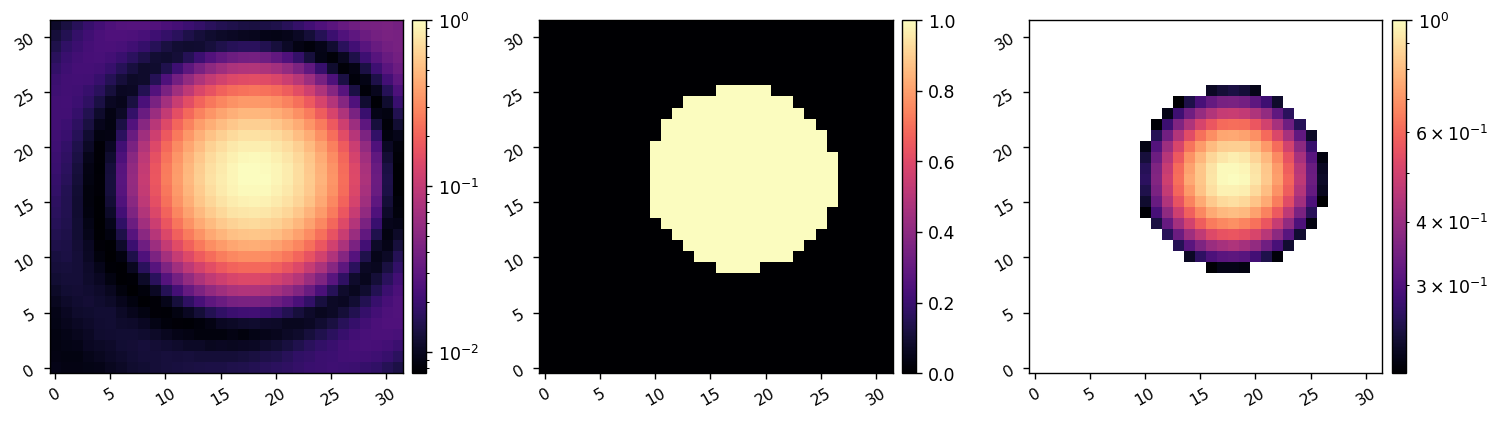

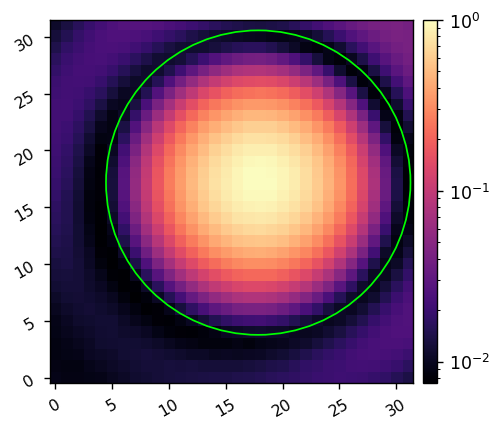

In [57]:
cam.Nframes = 1000
im_bias = cam.snap()

reload(utils)
cen = utils.centroid(im_bias, thresh=0.2, plot=True)
imshow1(im_bias, lognorm=True, patches=[Circle(cen, 1.22/pxscl_lamD, fill=False, color='lime')])


# Setup FSM Interface

In [83]:
fsm = ImageStream('dm00disp00')

In [96]:
fsm.write(v_bias)

In [80]:
fsm.write(zero)

# Do a latency test.

In [21]:
# Setup the directories to which the FSM and campupil data will be stored.

exp_dir = 'latency-exp'

subprocess.run(['mkdir',f'{cwd}/data/{exp_dir}'])

mkdir: cannot create directory ‘/home/uasal/Projects/fsm-exps/data/latency-exp’: File exists


CompletedProcess(args=['mkdir', '/home/uasal/Projects/fsm-exps/data/latency-exp'], returncode=1)

In [97]:
# Define the FSM step amount
amp = 0.1*as_per_lamD
v_step = fsm_utils.get_fsm_volts(tip=amp, tilt=0*u.arcsec)
# v_step = fsm_utils.get_fsm_volts(tip=0*u.arcsec, tilt=amp)
# v_step = fsm_utils.get_fsm_volts(tip=amp/np.sqrt(2), tilt=amp/np.sqrt(2))
print(v_step)

[[50.30884174]
 [49.84557913]
 [49.84557913]]


In [98]:
# Do the latency test

toggle_telem_campupil(1)
toggle_telem_fsm(1)
time.sleep(0.05)

fsm.write(v_step)

time.sleep(0.05)
toggle_telem_campupil(0)
toggle_telem_fsm(0)

# Extract and analyze the data from the test.

In [99]:
# Decompress the .xrif files from the telem_* apps into the desired data directories

exp_dir = 'latency-exp'
exp_path = f'{cwd}/data/{exp_dir}'

subprocess.run(['xrif2fits','-d','/opt/MagAOX/telem/campupil/','-D',exp_path])
clear_output()
subprocess.run(['xrif2fits','-d','/opt/MagAOX/telem/fsm/','-D',exp_path])
clear_output()

In [91]:
# Remove the xrif data files 
subprocess.run(['rm','-rf','/opt/MagAOX/telem/campupil/*.xrif'])
subprocess.run(['rm','-rf','/opt/MagAOX/telem/fsm/*.xrif'])

CompletedProcess(args=['rm', '-rf', '/opt/MagAOX/telem/fsm/*.xrif'], returncode=0)

In [100]:
import glob
from pathlib import Path

exp_dir = 'latency-exp'

dir_path = Path(f'{cwd}/data/{exp_dir}')  # Replace with the actual directory path

# cam_data_fnames = sorted(glob.glob(str(dir_path/'campupil*20250127*.fits')))
# fsm_data_fnames = sorted(glob.glob(str(dir_path/'fsm*20250127*.fits')))
cam_data_fnames = sorted(glob.glob(str(dir_path/'campupil*20250128*.fits')))
fsm_data_fnames = sorted(glob.glob(str(dir_path/'dm00disp00*20250128*.fits')))
fsm_data_fnames

['/home/uasal/Projects/fsm-exps/data/latency-exp/dm00disp00_20250128225524105735404.fits']

In [101]:
start_frame_time = float(cam_data_fnames[0].split("_")[1][12:-5])/1e9
print(start_frame_time)

frames = []
times = []
for fname in cam_data_fnames:
    frames.append(fits.getdata(fname))
    times.append(float(fname.split("_")[1][12:-5])/1e9)
frames = np.array(frames) 
times = np.array(times)
times = times - times[0]



24.056458319


In [102]:
fsm_command_time = float(fsm_data_fnames[-1].split("_")[1][12:-5])/1e9 - start_frame_time
fsm_command_time

0.04927708499999994

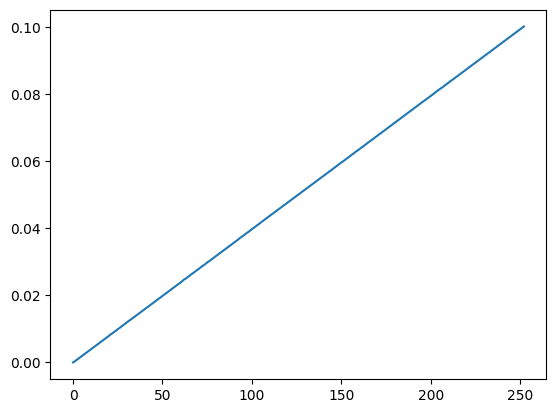

In [103]:
plt.plot(times)

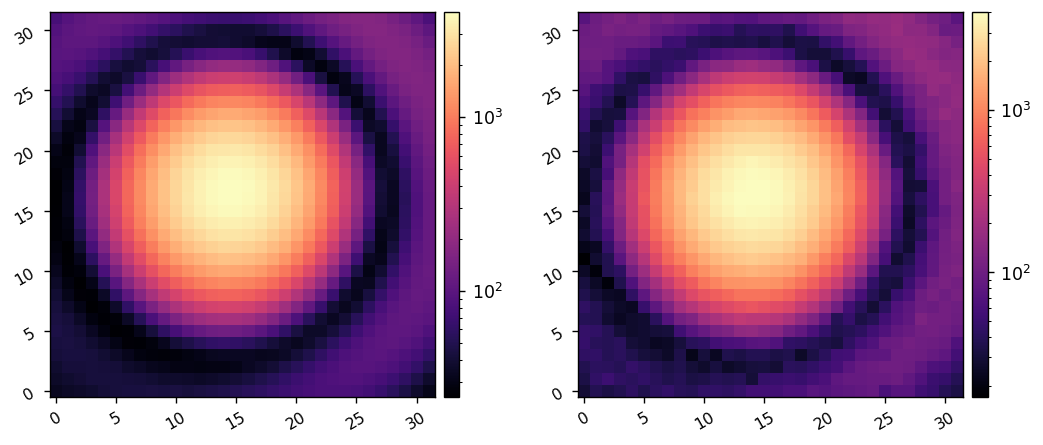

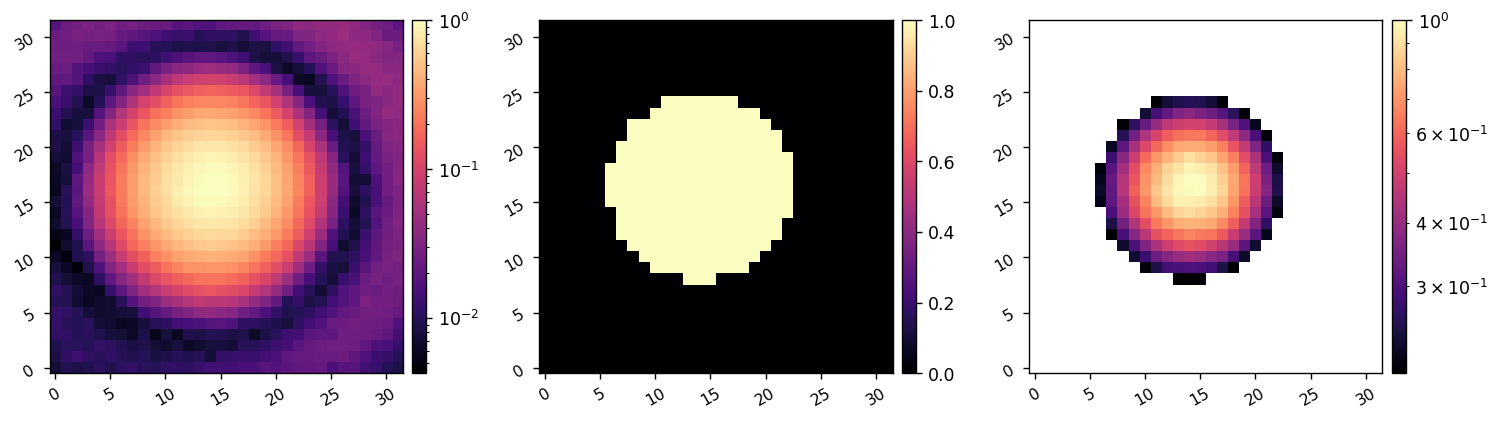

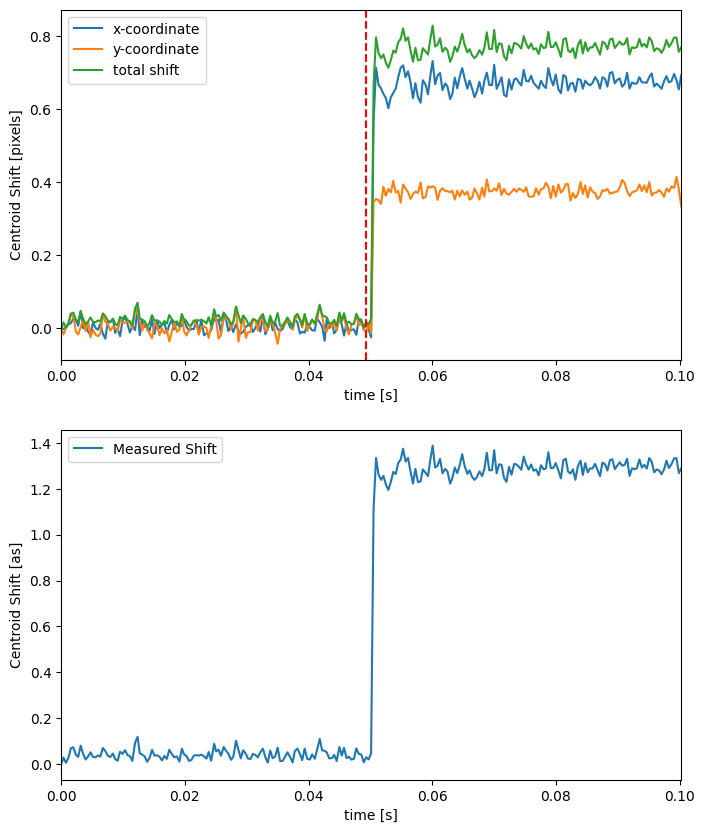

In [104]:
cthresh = 0.2

N = len(cam_data_fnames)
mean_frame = np.mean(frames, axis=0)
imshow2(mean_frame, frames[0], lognorm=True)

shift_pix = []
cen_0 = utils.centroid(frames[0].astype(float), thresh=cthresh, plot=True)
for i in range(N):
    cen = utils.centroid(frames[i].astype(float), thresh=cthresh, plot=0)
    shift = cen - cen_0
    shift_pix.append(shift)
shift_pix = np.array(shift_pix)

shift_pix[:,0] = shift_pix[:,0] - shift_pix[0,0]
shift_pix[:,1] = shift_pix[:,1] - shift_pix[0,1]

total_shift = np.sqrt( np.sum( np.square(shift_pix), axis=1) )

shift_as = shift_pix * pxscl_lamD * as_per_lamD # pixels * (lamD/pixel) * (as/lamD)
shift_as = np.sqrt( np.sum( np.square(shift_as), axis=1) )

fig = plt.figure(figsize=(8,10))
plt.subplot(211)
plt.plot(times, shift_pix[:,0], label='x-coordinate')
plt.plot(times, shift_pix[:,1], label='y-coordinate')
plt.plot(times, total_shift, label='total shift')
plt.axvline(x=fsm_command_time, color='red', linestyle='--')
plt.ylabel('Centroid Shift [pixels]')
plt.xlabel('time [s]')
plt.xlim([0,times.max()])
plt.legend()

plt.subplot(212)
plt.plot(times, shift_as, label='Measured Shift')
plt.ylabel('Centroid Shift [as]')
plt.xlabel('time [s]')
plt.xlim([0,times.max()])
# plt.xlim([0, 1])
plt.legend()

# plt.subplots_adjust(hspace=0.25)
# plt.show()

0.0012341710000001171


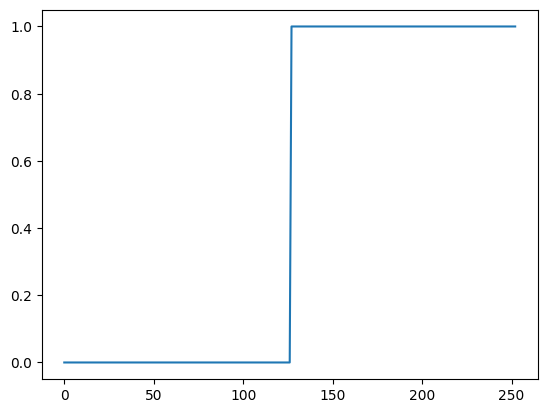

In [112]:
shift_bool = total_shift>0.075
shift_index = np.where(shift_bool == 1)[0][0]
latency = times[shift_index] - fsm_command_time
print(latency)
plt.plot(shift_bool)

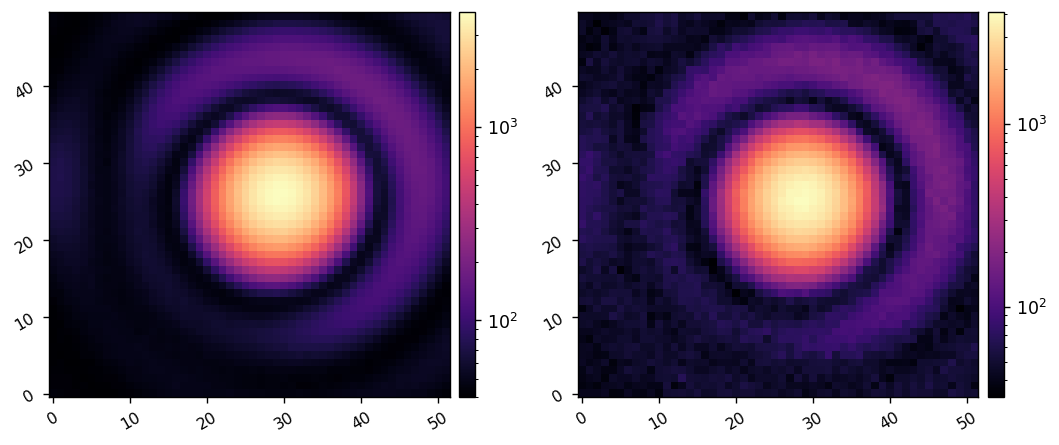

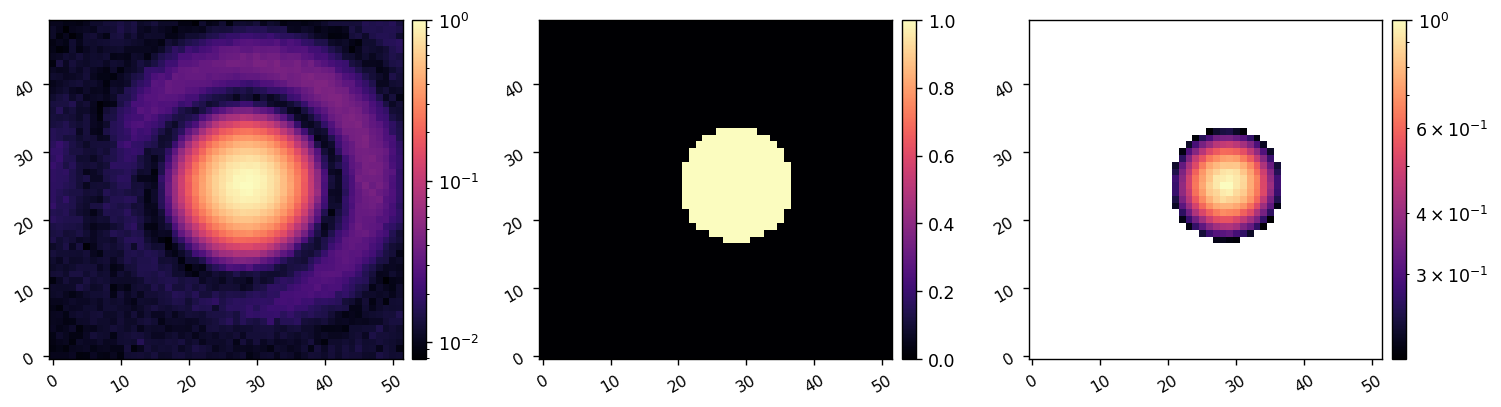

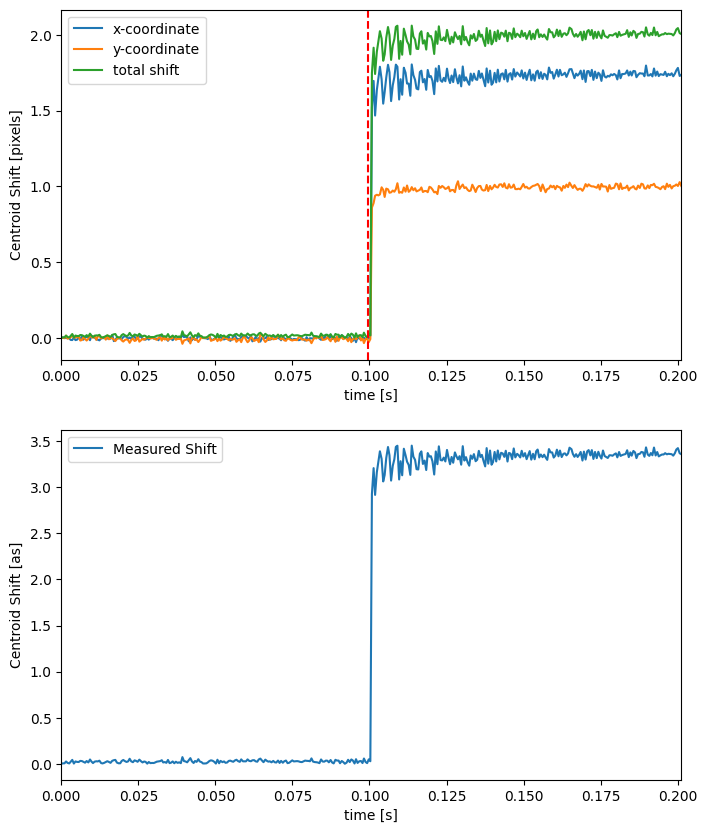

In [ ]:
cthresh = 0.2

N = len(cam_data_fnames)
mean_frame = np.mean(frames, axis=0)
imshow2(mean_frame, frames[0], lognorm=True)

shift_pix = []
cen_0 = utils.centroid(frames[0].astype(float), thresh=cthresh, plot=True)
for i in range(N):
    cen = utils.centroid(frames[i].astype(float), thresh=cthresh, plot=0)
    shift = cen - cen_0
    shift_pix.append(shift)
shift_pix = np.array(shift_pix)

shift_pix[:,0] = shift_pix[:,0] - shift_pix[0,0]
shift_pix[:,1] = shift_pix[:,1] - shift_pix[0,1]

total_shift = np.sqrt( np.sum( np.square(shift_pix), axis=1) )

shift_as = shift_pix * pxscl_lamD * as_per_lamD # pixels * (lamD/pixel) * (as/lamD)
shift_as = np.sqrt( np.sum( np.square(shift_as), axis=1) )

fig = plt.figure(figsize=(8,10))
plt.subplot(211)
plt.plot(times, shift_pix[:,0], label='x-coordinate')
plt.plot(times, shift_pix[:,1], label='y-coordinate')
plt.plot(times, total_shift, label='total shift')
plt.axvline(x=fsm_command_time, color='red', linestyle='--')
plt.ylabel('Centroid Shift [pixels]')
plt.xlabel('time [s]')
plt.xlim([0,times.max()])
plt.legend()

plt.subplot(212)
plt.plot(times, shift_as, label='Measured Shift')
plt.ylabel('Centroid Shift [as]')
plt.xlabel('time [s]')
plt.xlim([0,times.max()])
# plt.xlim([0, 1])
plt.legend()

# plt.subplots_adjust(hspace=0.25)
# plt.show()

In [3]:
100 * 100 * 4/1e9 * 250 * 3600

36.0

0.0014196420000000265


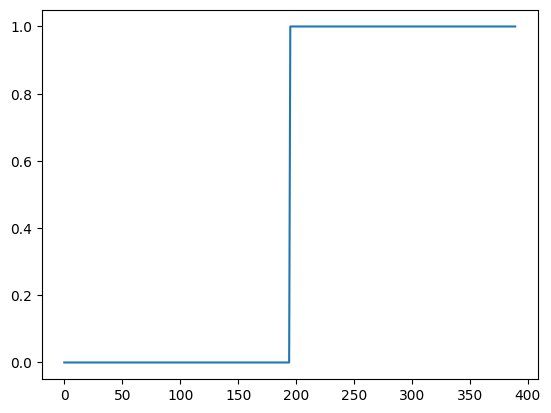

In [32]:
shift_bool = total_shift>0.05
shift_index = np.where(shift_bool == 1)[0][0]
latency = times[shift_index] - fsm_command_time
print(latency)
plt.plot(shift_bool)